# dicom->png 로 변환

In [1]:
import glob
import os

# dicom 폴더 지정
train_dicom_dir = os.path.expanduser('~/Downloads/아주대 백업/dataset/rsna_hemorrhage_kaggle/rsna-intracranial-hemorrhage-detection/stage_1_train_images/')

li = glob.glob(train_dicom_dir+'*.dcm')
li[0]

'/Users/jmjeon/Downloads/아주대 백업/dataset/rsna_hemorrhage_kaggle/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_9baef8430.dcm'

In [2]:
# dicom 이미지 변환 및 확인
import pydicom
import matplotlib.pyplot as plt
import numpy as np

def get_image_8bits(img, window_center, window_width):

    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    img = normalize_minmax(img).astype(np.int)
    
    return img

def get_image_24bits(img, window_center, window_width):
    
    imgs = []
    for i in range(len(window_center)):
        imgs.append(get_image_8bits(img.copy(), window_center[i], window_width[i]))
    imgs = np.array(imgs)
    
    return imgs.transpose(1,2,0)

def window_image(img, window_center, window_width, intercept, slope):
    
    img = (img * slope + intercept)
    
    if type(window_center) is int:
        return get_image_8bits(img, window_center, window_width)
    
    if len(window_center)==1 and len(window_width)==1:
        return get_image_8bits(img, window_center[0], window_width[0])
        
    elif len(window_center)==3 and len(window_width)==3:
        return get_image_24bits(img, window_center, window_width)
    
    else:
        raise ValueError('Window Center, Width is not supported value [{},{}]'.format(window_center, window_width))

        
    return img 

def get_first_of_dicom_field_as_int(x):
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_meta_from_dicom(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def normalize_minmax(img):
    mi, ma = img.min(), img.max()
    return 255 * (img - mi) / (ma - mi)

def get_img_from_dicom_dir(dicom_dir, window=False):
    dicom = pydicom.read_file(dicom_dir)
    meta = get_meta_from_dicom(dicom)
    
    if not window or not window[0]:
        dcm_img = window_image(dicom.pixel_array, *meta)
    else:
        dcm_img = window_image(dicom.pixel_array, window[0], window[1], meta[2], meta[3])
    
    return dcm_img

dicom min value: 0 , max value: 2673
After windowing, normalize min value: 0 , max value: 255


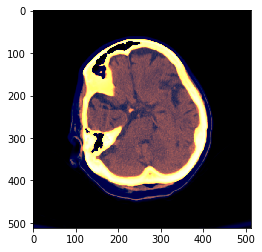

In [3]:
window_index = 2
windows = [
    ([],[]), # 0번: dicom 내의 window center, window width 사용
    ([40],[80]), # 1번: 1채널로 window center, width를 각각 40, 80으로 사용
    ([40, 80, 600], [80, 200, 2800]) # 2번: 3채널로 (40,80), (80,200), (600,2800)으로 사용
]
window = windows[window_index]

# get dicom
dcm = pydicom.read_file(li[22])
dcm_img = dcm.pixel_array

# dicom의 pixel 중 min,max 값
print('dicom min value:', dcm_img.min(), ', max value:', dcm_img.max())

img = window_image(dcm_img, [40], [80], dcm.RescaleIntercept, dcm.RescaleSlope)
print('After windowing, normalize min value:', img.min(), ', max value:', img.max())

img = get_img_from_dicom_dir(li[22], window=window)

plt.imshow(img, 'gray')
plt.show()

# png파일로 저장

In [7]:
import PIL
import numpy as np

def save_img(img, save_dir):
    if len(img.shape)==2:
        im = PIL.Image.fromarray((img).astype(np.int8), mode='L')
    else:
        im = PIL.Image.fromarray((img).astype(np.int8), mode='RGB')
    im.save(save_dir)

save_img(img, 'test.png')

# 환자 단위 slice 찾기

In [147]:
import pandas as pd
import os

path = 'stage_1_train_cls.csv'
# csv 확인
df = pd.read_csv(path)
df.head(1)

,filename,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,patient_id,study_instance_uid,series_instance_uid,image_position,samples_per_pixel,pixel_spacing,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope
0,ID_63eb1e259,0,0,0,0,0,0,ID_a449357f,ID_62d125e5b2,ID_0be5c0d1b3,"['-125', '-8', '180.199951']",1,"['0.48828125', '0.48828125']",0,"['00036', '00036']","['00080', '00080']",-1024.0,1.0


In [148]:
# study_instance_uid, patient_id의 unique한 id 개수
df.study_instance_uid.unique().shape, df.patient_id.unique().shape

((19530,), (17079,))

In [149]:
# 임의의 한 환자 slice 확인
sample_study_uid = df.study_instance_uid.unique()[0]
sample_study_uid

'ID_62d125e5b2'

In [150]:
# 한 환자의 df 생성
sample_df = df[df['study_instance_uid']==sample_study_uid].copy()

In [151]:
# position이 str로 되어있어서 (x,y,z) 중 z값만 float형태로 가져옴
position2 = sample_df.image_position.apply(lambda x:float(x.split(',')[2][2:-2]))
sample_df['Position2'] = position2
sample_df.sort_values(by='Position2').head()

,filename,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,patient_id,study_instance_uid,series_instance_uid,image_position,samples_per_pixel,pixel_spacing,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope,Position2
637496,ID_d3eaf5452,0,0,0,0,0,0,ID_a449357f,ID_62d125e5b2,ID_0be5c0d1b3,"['-125', '-8', '5.19995117']",1,"['0.48828125', '0.48828125']",0,"['00036', '00036']","['00080', '00080']",-1024.0,1.0,5.199951
339240,ID_84cd9c956,0,0,0,0,0,0,ID_a449357f,ID_62d125e5b2,ID_0be5c0d1b3,"['-125', '-8', '10.1999512']",1,"['0.48828125', '0.48828125']",0,"['00036', '00036']","['00080', '00080']",-1024.0,1.0,10.199951
618231,ID_53ec1c229,0,0,0,0,0,0,ID_a449357f,ID_62d125e5b2,ID_0be5c0d1b3,"['-125', '-8', '15.1999512']",1,"['0.48828125', '0.48828125']",0,"['00036', '00036']","['00080', '00080']",-1024.0,1.0,15.199951
81483,ID_6a0764005,0,0,0,0,0,0,ID_a449357f,ID_62d125e5b2,ID_0be5c0d1b3,"['-125', '-8', '20.1999512']",1,"['0.48828125', '0.48828125']",0,"['00036', '00036']","['00080', '00080']",-1024.0,1.0,20.199951
623100,ID_272504a24,0,0,0,0,0,0,ID_a449357f,ID_62d125e5b2,ID_0be5c0d1b3,"['-125', '-8', '25.1999512']",1,"['0.48828125', '0.48828125']",0,"['00036', '00036']","['00080', '00080']",-1024.0,1.0,25.199951


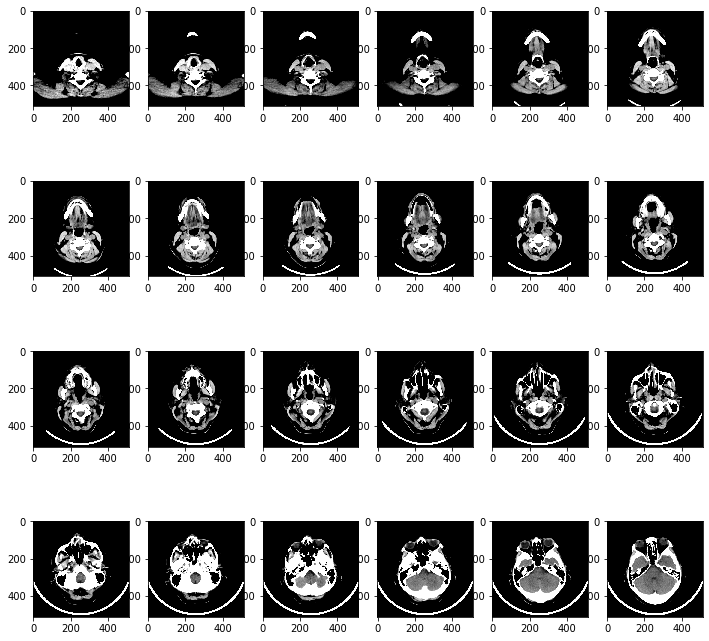

In [152]:
# position2를 기준으로 sequence한 데이터가 맞는지 확인
filenames = sample_df.sort_values(by='Position2').filename
filenames = filenames.apply(lambda x:x+'.dcm')

plt.figure(figsize=(12,12))
for i, fn in enumerate(filenames):
    img = get_img_from_dicom_dir(train_dicom_dir+fn)
    plt.subplot(4,6,i+1)
    plt.imshow(img, 'gray')
    
    if i+1==24:
        break
    
plt.show()


In [161]:
# study_instance_uid를 기준으로 환자당 몇 장의 slice가 있는지 확인
df['study_instance_uid'].value_counts().describe()

# ->아래로부터 환자 단위로 최소20장, 최대 60장, 평균은 34장씩의 slice가 있음을 알 수 있다.

count    19530.000000
mean        34.524424
std          4.993820
min         20.000000
25%         32.000000
50%         33.000000
75%         37.000000
max         60.000000
Name: study_instance_uid, dtype: float64

In [182]:
header=['filename', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any', 'patient_id', 'study_instance_uid', 'series_instance_uid', 'image_position', 'samples_per_pixel', 'pixel_spacing', 'pixel_representation', 'window_center', 'window_width', 'rescale_intercept', 'rescale_slope', 'Position2', 'slice_id']
train_df = pd.DataFrame(columns=header)
train_df

,filename,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,patient_id,study_instance_uid,series_instance_uid,image_position,samples_per_pixel,pixel_spacing,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope,Position2,slice_id


# 100명의 환자만 새로운 dataframe로 저장

In [199]:
from tqdm.notebook import tqdm

uids = df.study_instance_uid.unique()
n_patient = 100
header=['filename', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any', 'patient_id', 'study_instance_uid', 'series_instance_uid', 'image_position', 'samples_per_pixel', 'pixel_spacing', 'pixel_representation', 'window_center', 'window_width', 'rescale_intercept', 'rescale_slope', 'Position2', 'slice_id']
train_df = pd.DataFrame(columns=header)

for uid in tqdm(uids[:n_patient]):
    
    # 환자단위 dataframe가져오기
    tmp_df = df[df['study_instance_uid']==uid].copy()
    
    # position2를 기준으로 정렬
    position2 = tmp_df.image_position.apply(lambda x:float(x.split(',')[2][2:-2]))
    tmp_df['Position2'] = position2
    tmp_df = tmp_df.sort_values(by='Position2')
    
    # slice id 추가
    tmp_df['slice_id']=range(len(position2))
    
    train_df = pd.concat([train_df,tmp_df])

# 저장
train_df.to_csv('stage_1_train_cls_only100.csv', index=None)


# 위 100명의 환자만 이미지 파일로 저장

In [203]:
img_save_dir = os.path.expanduser('~/dataset/kaggle_rsna(only100)/imgs/')

for fn in tqdm(train_df.filename):
    fn_dcm = fn+'.dcm'
    fn_png = fn+'.png'
    img = get_img_from_dicom_dir(train_dicom_dir+fn_dcm, window)
    save_img(img, img_save_dir+fn_png)

/Users/jmjeon/venv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
